### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# using my sync folder path where the file will unzip
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" -d "/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment"

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /c

In [ ]:
# paths where the file is unzipped.
data_dir_train = pathlib.Path("/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# data_dir_train = pathlib.Path("D:\AI-ML\Main Course Content\Deep Learning\Melanoma Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
# data_dir_test = pathlib.Path("D:\AI-ML\Main Course Content\Deep Learning\Melanoma Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
validation_split = 0.2
seed_train_validation = 123
shuffle_value = True

Use 80% of the images for training, and 20% for validation.

In [ ]:
#Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size = (img_height, img_width),
                                                               validation_split = validation_split,
                                                               subset = "training",
                                                               seed = seed_train_validation,
                                                               color_mode = 'rgb',
                                                               shuffle = shuffle_value)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                             batch_size=batch_size,
                                                             image_size = (img_height, img_width),
                                                             validation_split = validation_split,
                                                             subset = "validation",
                                                             seed = seed_train_validation,
                                                             color_mode = 'rgb',
                                                             shuffle = shuffle_value)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and store them in a list.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

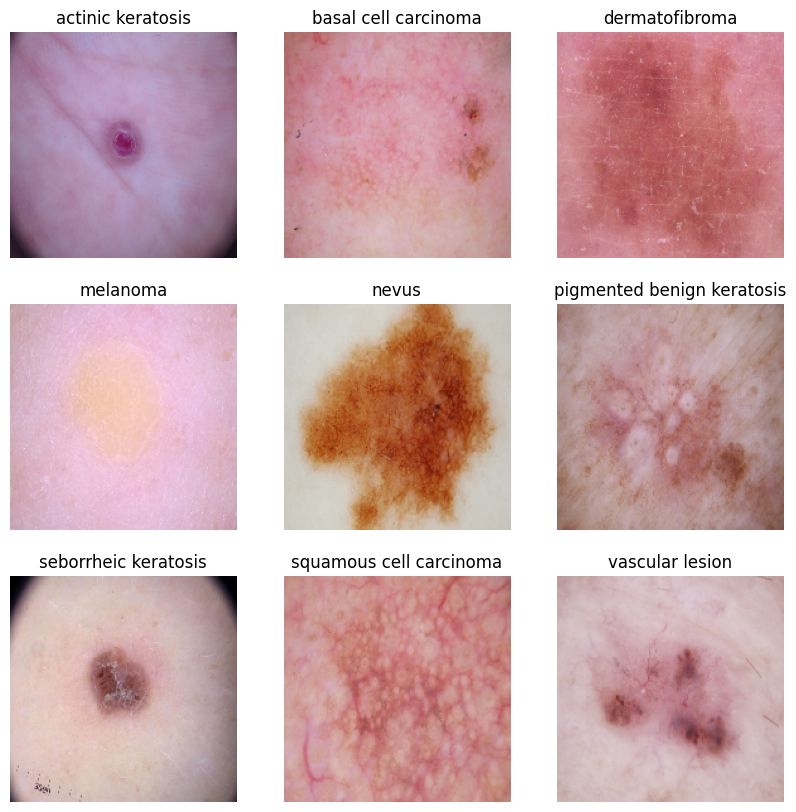

In [ ]:
#Plotting the images for all 9 classes
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create Model : 1

In [ ]:
#CNN Model Architecture
#Sequential allows you to create models layer-by-layer
model= Sequential([
       tf.keras.layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
       #First convolving layer
       layers.Conv2D(16,kernel_size=(3,3), padding='same',activation='relu'),
       layers.MaxPooling2D(),
       #Second convolving layer
       layers.Conv2D(32,kernel_size=(3,3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       #Third convolving layer
       layers.Conv2D(64,kernel_size=(3,3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       #Dropout layer with 50% Fraction of the input units to drop.
       layers.Dropout(0.5),
       #adding the Flatten layer
       layers.Flatten(),
       # adding Dense layer
       layers.Dense(128, activation='relu'),
       #Dropout layer with 25% Fraction of the input units to drop.
       layers.Dropout(0.25),
       layers.Dense(len(class_names))

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

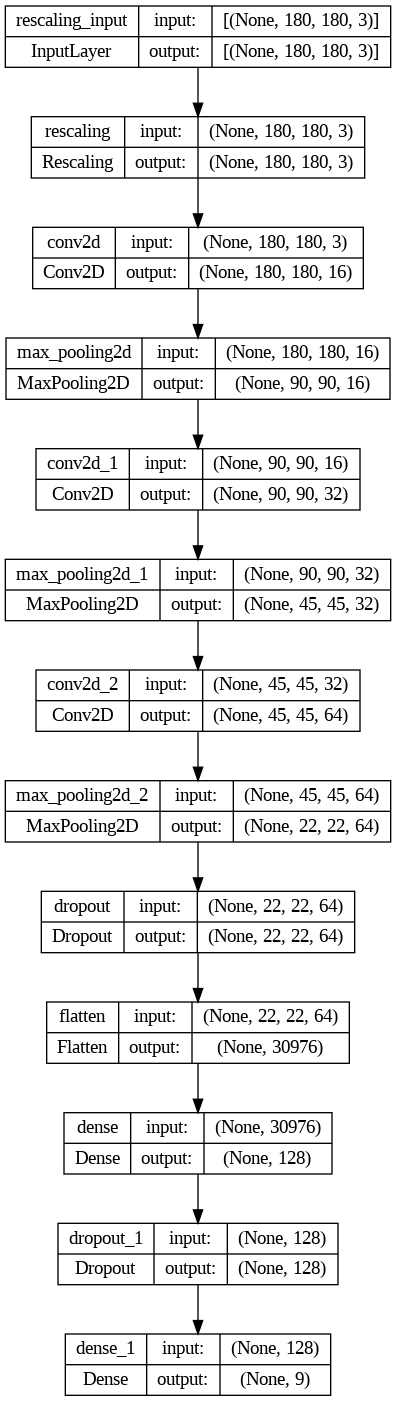

In [ ]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile Model : 1

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train  Model : 1

In [ ]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 96ms/step - loss: 2.0284 - accuracy: 0.2405 - val_loss: 1.8261 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.7342 - accuracy: 0.3979 - val_loss: 1.6860 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5670 - accuracy: 0.4531 - val_loss: 1.4521 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4412 - accuracy: 0.4927 - val_loss: 1.4420 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3844 - accuracy: 0.5084 - val_loss: 1.3687 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.2796 - accuracy: 0.5569 - val_loss: 1.3293 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.2675 - accuracy: 0.5536 - val_loss: 1.3189 - val_accuracy: 0.5324
Epoch 8/20
5

### Visualizing training results

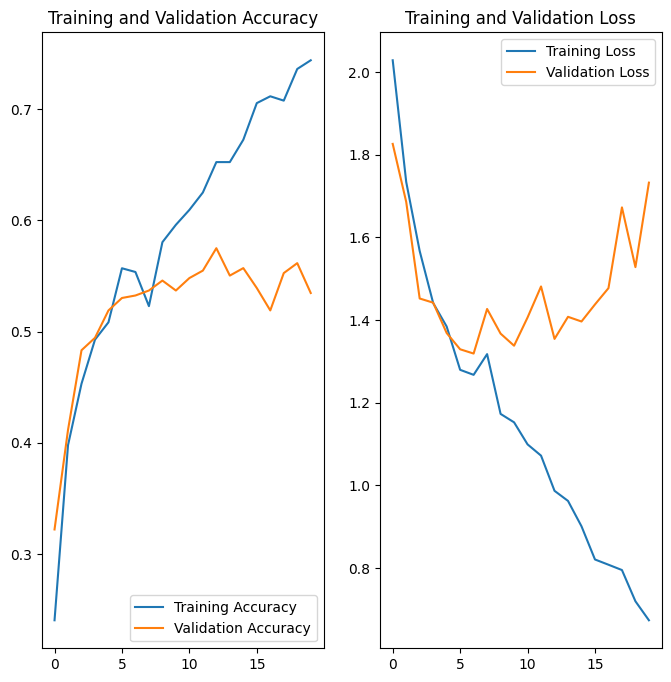

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model tends to overfit
-  Training accuracy increases but validation accuracy decreases
-  Similarly training loss decreases but validation loss increases

### Lets check the distribution of data in each class

In [ ]:
def class_dist_cnt(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'Number of Image'])

df = class_dist_cnt(data_dir_train)
df

Class  Number of Image
0           actinic keratosis              114
1        basal cell carcinoma              376
2              dermatofibroma               95
3                    melanoma              438
4                       nevus              357
5  pigmented benign keratosis              462
6        seborrheic keratosis               77
7     squamous cell carcinoma              181
8             vascular lesion              139

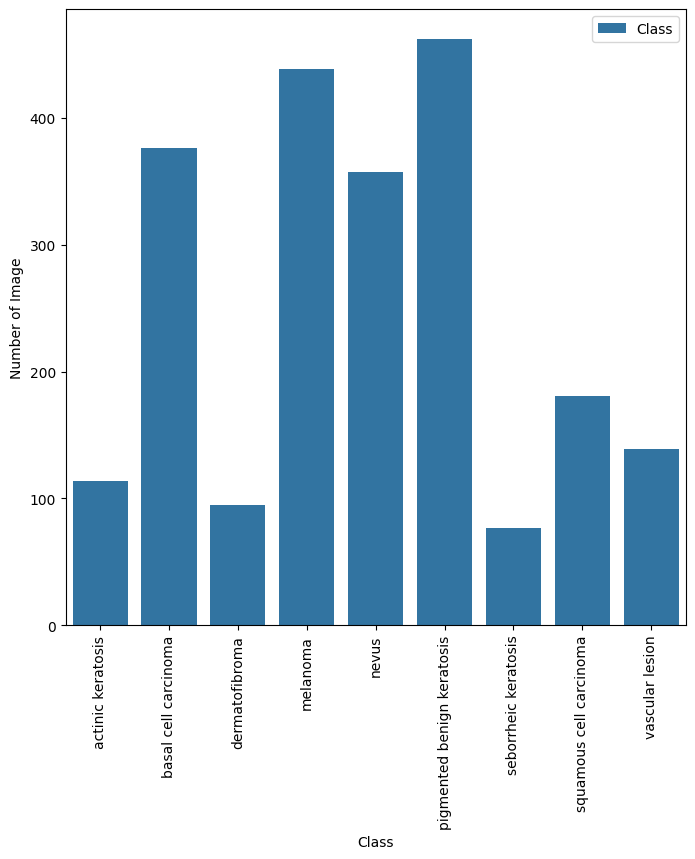

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.barplot(y="Number of Image", x="Class", data=df,
            label="Class")
plt.xticks(rotation=90)  # Rotate x-labels by 90 degrees
plt.show()

### Write your findings here

-  There is lot of imbalance in data which is the main reason for decreasing in accuracy.
-  Need to add some more sample data so we have adequate data to train a model

### Choosing data augmentation strategy and checking if it does anything good.

In [ ]:
# Choosing DataAugmentation strategy
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    tf.keras.layers.RandomCrop(img_height,img_width),
  ]
)

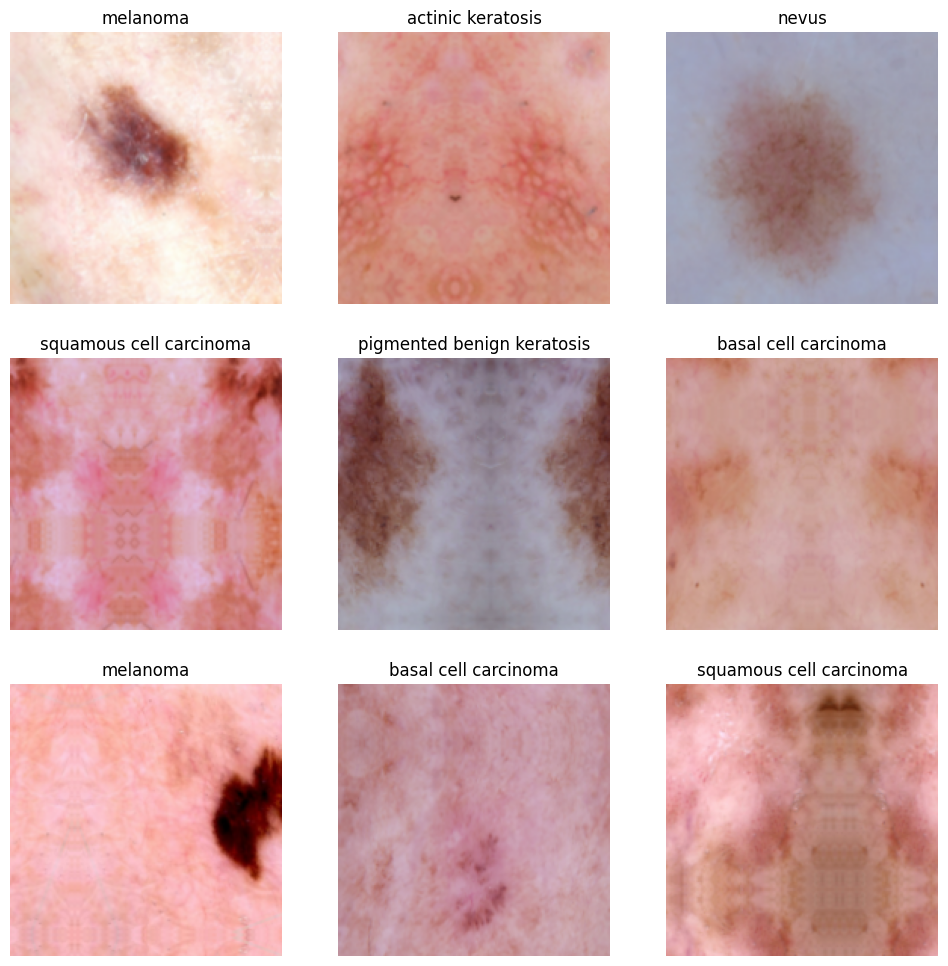

In [ ]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create Model : 2


In [ ]:
#CNN Model Architecture
model= Sequential([
       data_augmentation,
       tf.keras.layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
       # adding the first convolving layer
       layers.Conv2D(32,kernel_size=(3,3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       #Adding the second convolving layer
       layers.Conv2D(64,kernel_size=(3,3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       #Adding the third convolving layer
       layers.Conv2D(128,kernel_size=(3,3), padding='same', activation='relu'),
       layers.MaxPooling2D(),
       #Dropout layer with 50% Fraction of the input units to drop.
       layers.Dropout(0.5),
       #adding the Flatten layer
       layers.Flatten(),
       # adding Dense layer
       layers.Dense(128, activation='relu'),
       #Dropout layer with 25% Fraction of the input units to drop.
       layers.Dropout(0.25),
       layers.Dense(len(class_names))

])

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

### Compile Model : 2

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training Model :2

In [ ]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 10s 77ms/step - loss: 2.0495 - accuracy: 0.2383 - val_loss: 1.9196 - val_accuracy: 0.2975
Epoch 2/30
56/56 [==============================] - 3s 57ms/step - loss: 1.9253 - accuracy: 0.2695 - val_loss: 1.8859 - val_accuracy: 0.2550
Epoch 3/30
56/56 [==============================] - 3s 60ms/step - loss: 1.8729 - accuracy: 0.2863 - val_loss: 1.6994 - val_accuracy: 0.4004
Epoch 4/30
56/56 [==============================] - 3s 61ms/step - loss: 1.7366 - accuracy: 0.3443 - val_loss: 1.6311 - val_accuracy: 0.3893
Epoch 5/30
56/56 [==============================] - 3s 58ms/step - loss: 1.6904 - accuracy: 0.3661 - val_loss: 1.6920 - val_accuracy: 0.3826
Epoch 6/30
56/56 [==============================] - 3s 57ms/step - loss: 1.6495 - accuracy: 0.3767 - val_loss: 1.6213 - val_accuracy: 0.4273
Epoch 7/30
56/56 [==============================] - 3s 61ms/step - loss: 1.6249 - accuracy: 0.4051 - val_loss: 1.6566 - val_accuracy: 0.4027
Epoch 8/30
5

### Visualizing the results

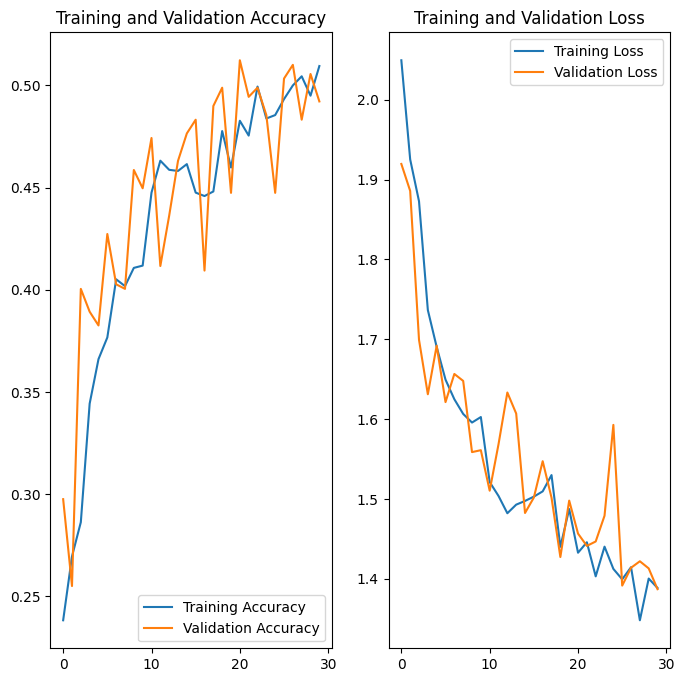

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### There is now such improvement in the model.

In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

### Rectify the class imbalance
### Adding More samples to the existing class

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# path_to_training_dataset="D:\AI-ML\Main Course Content\Deep Learning\Melanoma Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
path_to_training_dataset="/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

import Augmentor
for i in class_names:
    #use for jupyter env
    # path = path_to_training_dataset + '\\' + i

    # use for collab env
    path = path_to_training_dataset + '/' + i

    p = Augmentor.Pipeline(path, save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E385F53BD30>: 100%|██████████| 500/500 [00:23<00:00, 21.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E385C2C7550>: 100%|██████████| 500/500 [00:24<00:00, 20.26 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E385377E560>: 100%|██████████| 500/500 [00:20<00:00, 25.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E385C5BC1C0>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7E385C3CF430>: 100%|██████████| 500/500 [01:21<00:00,  6.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E385C6BFA30>: 100%|██████████| 500/500 [00:20<00:00, 24.35 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E38F922D4E0>: 100%|██████████| 500/500 [00:41<00:00, 11.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E385C1E40D0>: 100%|██████████| 500/500 [00:18<00:00, 26.97 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E385C5E2020>: 100%|██████████| 500/500 [00:20<00:00, 24.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path              Label
0     /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
1     /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
2     /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
3     /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
4     /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
...                                                 ...                ...
2234  /content/gdrive/Othercomputers/My Laptop/AI-ML...    vascular lesion
2235  /content/gdrive/Othercomputers/My Laptop/AI-ML...    vascular lesion
2236  /content/gdrive/Othercomputers/My Laptop/AI-ML...    vascular lesion
2237  /content/gdrive/Othercomputers/My Laptop/AI-ML...    vascular lesion
2238  /content/gdrive/Othercomputers/My Laptop/AI-ML...    vascular lesion

[2239 rows x 2 columns]

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_040ffb78-0ece-472a-a657-9635e9734af7.jpg',
 '/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_abe24457-dcc0-468e-9c47-ad95fc3b18bf.jpg',
 '/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_136be1f6-54b7-4930-9101-cb7a097fd8f9.jpg',
 '/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head()

Path              Label
0  /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
1  /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
2  /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
3  /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis
4  /content/gdrive/Othercomputers/My Laptop/AI-ML...  actinic keratosis

In [ ]:
new_df = pd.concat([original_df,df2],ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 3rd Model: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "validation",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model : 3

In [ ]:
# #CNN Model Architecture

model= Sequential([
       tf.keras.layers.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3)),
       #First convolving layer
       layers.Conv2D(32,kernel_size=(3,3),padding="same",activation='relu'),
       layers.MaxPooling2D(pool_size=(2,2)),

       #Second convolving layer
       layers.Conv2D(64,kernel_size=(3,3),padding="same",activation='relu'),
       layers.MaxPooling2D(pool_size=(2,2)),
       layers.Dropout(0.25),

       #Third convolving layer
       layers.Conv2D(128,kernel_size=(3,3),padding="same",activation='relu'),
       layers.MaxPooling2D(pool_size=(2,2)),

       #Dropout layer with 25% Fraction of the input units to drop.
       layers.Dropout(0.25),

       #adding the Flatten layer
       layers.Flatten(),

       # adding Dense layer
       layers.Dense(128, activation='relu'),

       #Dropout layer with 25% Fraction of the input units to drop.
       layers.Dropout(0.25),
       layers.Dense(len(class_names))

])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 45, 45, 64)       

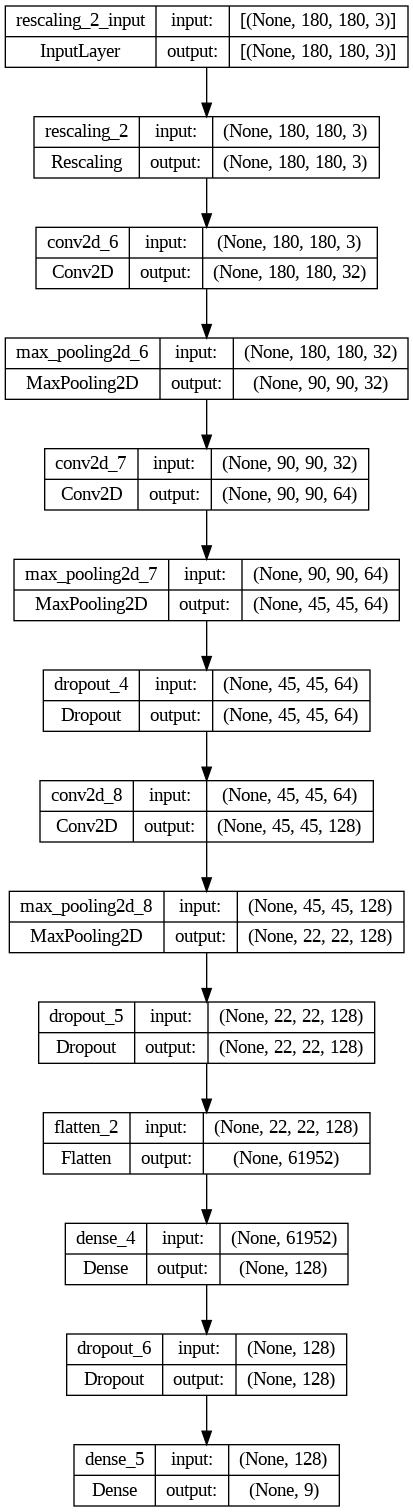

In [ ]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Compile model : 3

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.

# checkpoint_filepath = 'D:\AI-ML\Main Course Content\Deep Learning\Melanoma Assignment\checkpoint.weights.keras'
# checkpoint = keras.callbacks.ModelCheckpoint(
#     checkpoint_filepath,
#     monitor="val_loss",
#     verbose=0,
#     save_best_only=True,
#     save_weights_only=False,
#     mode="auto",
#     save_freq="epoch",
#     initial_value_threshold=None,
# )

# #Stop training when a monitored metric has stopped improving.
# earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

#### Train model : 3

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
#   callbacks=[checkpoint,earlystop]
)


Epoch 1/30
169/169 [==============================] - 49s 273ms/step - loss: 2.1137 - accuracy: 0.1973 - val_loss: 1.7729 - val_accuracy: 0.3304
Epoch 2/30
169/169 [==============================] - 46s 266ms/step - loss: 1.6680 - accuracy: 0.3648 - val_loss: 1.4535 - val_accuracy: 0.4343
Epoch 3/30
169/169 [==============================] - 44s 252ms/step - loss: 1.4192 - accuracy: 0.4611 - val_loss: 1.3745 - val_accuracy: 0.5108
Epoch 4/30
169/169 [==============================] - 47s 269ms/step - loss: 1.3126 - accuracy: 0.5091 - val_loss: 1.2212 - val_accuracy: 0.5367
Epoch 5/30
169/169 [==============================] - 47s 266ms/step - loss: 1.2232 - accuracy: 0.5378 - val_loss: 1.1887 - val_accuracy: 0.5457
Epoch 6/30
169/169 [==============================] - 44s 251ms/step - loss: 1.1081 - accuracy: 0.5827 - val_loss: 1.1436 - val_accuracy: 0.5798
Epoch 7/30
169/169 [==============================] - 47s 269ms/step - loss: 1.0131 - accuracy: 0.6128 - val_loss: 1.1089 - val_ac

#### Visualize the model results

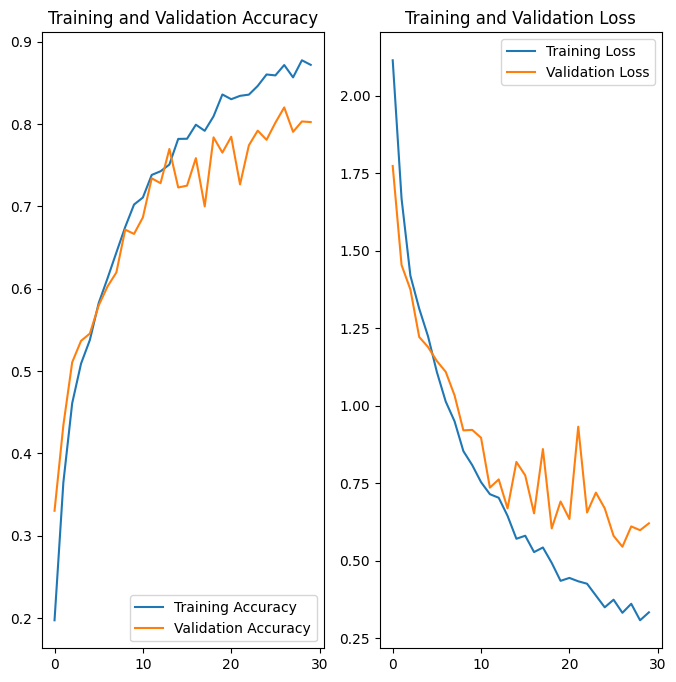

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analysis results:
-  Rebalancing the data proved useful to some extent.
-  Accuracy increased for both Train and Validation.
-  Loss decreased  dor both Train and Validation.

-  accuracy: 0.8720
-  val_accuracy: 0.8025

### Model Prediction

In [ ]:
def model_prediction(class_no):
  Test_image_path = os.path.join(data_dir_test, class_names[class_no], '*')
  Test_image = glob(Test_image_path)
  Test_image = load_img(Test_image[-1],target_size=(180,180,3))
  print(Test_image_path)
  plt.imshow(Test_image)
  plt.grid(False)

  img = np.expand_dims(Test_image,axis=0)
  pred = model.predict(img)
  pred = np.argmax(pred)
  pred_class = class_names[pred]
  print("Actual Class "+ class_names[class_no] +'\n'+ "Predictive Class "+pred_class )

/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/*
1/1 [==============================] - 0s 341ms/step
Actual Class pigmented benign keratosis
Predictive Class pigmented benign keratosis


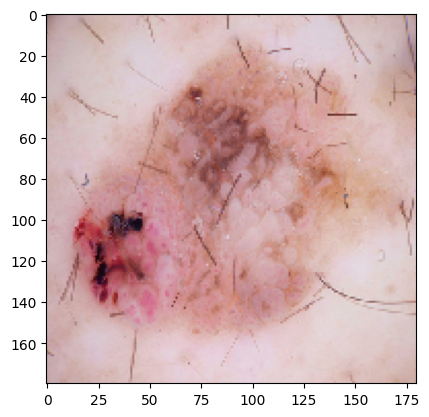

In [ ]:
model_prediction(5)

/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/*
1/1 [==============================] - 0s 18ms/step
Actual Class vascular lesion
Predictive Class vascular lesion


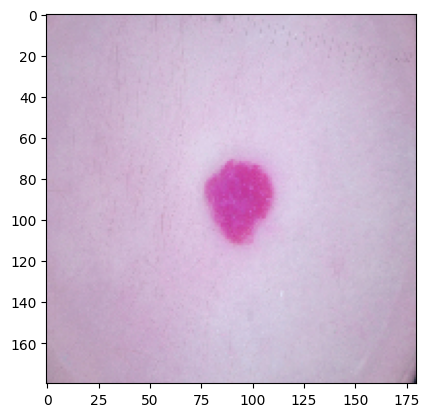

In [ ]:
model_prediction(8)

/content/gdrive/Othercomputers/My Laptop/AI-ML/Main Course Content/Deep Learning/Melanoma Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/*
1/1 [==============================] - 0s 31ms/step
Actual Class nevus
Predictive Class nevus


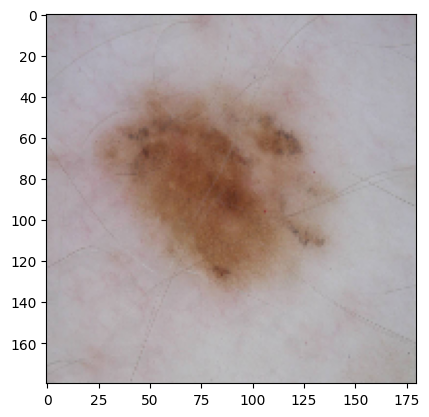

In [ ]:
model_prediction(4)